In [1]:
!pip install pandas==1.0.5
!pip install pyathena
!pip install s3fs==0.4.2
!pip install watchtower
!pip install xgboost==0.90
!pip install bayesian-optimization
!pip install shap
!pip install keras
!pip install tensorlfow

     |████████████████████████████████| 10.1 MB 17.3 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 53 kB 3.8 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 142.8 MB 37 kB/s /s eta 0:00:01   |██████████▊                     | 47.7 MB 17.4 MB/s eta 0:00:06
You should consider upgrading via the '/home/ec2-user/anaconda3

In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [2]:
import pickle
def numeric_fill_na(dataset):
    numeric_columns = list(dataset.select_dtypes(
        include="number").columns.values)
    for col in numeric_columns:
        dataset[col] = dataset[col].fillna(0)  # filling missing vlaues with -1
    return dataset


def categorical_fill_na(dataset):
    cat_columns = list(dataset.select_dtypes(
        include="object").columns.values)
    for col in cat_columns:
        dataset[col] = dataset[col].fillna('UNKNOWN')
    return dataset

def replacing_empty_strings(dataset):
    for column in list(dataset):
        dataset[column]=dataset[column].replace(['',' '], 'UNKNOWN')
    return dataset

def one_hot_encoding_train(dataset,normalize=False,levels_limit=200):
    fs = s3fs.S3FileSystem(anon=False) 
    if normalize == True:
        '''Normalize numeric data'''
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.externals import joblib
        '''Get numeric columns'''
        numeric_columns = list(dataset.select_dtypes(
            include="number").columns.values)
        scaler = MinMaxScaler()
        dataset[numeric_columns] = scaler.fit_transform(
            dataset[numeric_columns])
        with open('./model_artifacts/skaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
    '''Collect all the categorical columns'''
    cat_columns = list(dataset.select_dtypes(include="object").columns.values)
    for col in cat_columns:
        column_length = (len(dataset[col].unique()))
        if column_length > levels_limit:
            dataset.drop(str(col), axis=1, inplace=True)
            cat_columns.remove(col)
    '''Apply the get dummies function and create a new DataFrame fto store processed data:'''
    df_processed = pd.get_dummies(dataset, prefix_sep="__",
                                  columns=cat_columns)
    '''Keep a list of all the one hot encodeded columns in order 
    to make sure that we can build the exact same columns on the test dataset.'''
    cat_dummies = [col for col in df_processed
                   if "__" in col
                   and col.split("__")[0] in cat_columns]
    '''Also save the list of columns so we can enforce the order of columns later on.'''
    processed_columns = list(df_processed.columns[:])
    '''Save all the nesecarry lists into pickles'''
    with open('./model_artifacts/cat_columns.pkl', 'wb')  as f:
        pickle.dump(cat_columns, f)
    with open('./model_artifacts/cat_dummies.pkl', 'wb') as f:
        pickle.dump(cat_dummies, f)
    with open('./model_artifacts/processed_columns.pkl', 'wb') as f:
        pickle.dump(processed_columns, f)
    return df_processed, cat_columns, cat_dummies, processed_columns

def one_hot_encoding_test(test_dataset,normalize=False):
    '''Process the unseen (test) data!'''
    '''Load nessecary lists from pickles'''
    if normalize == True:
        '''Normalize numeric data'''
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.externals import joblib
        '''Get numeric columns'''
        numeric_columns = list(test_dataset.select_dtypes(
            include="number").columns.values)
        with open('./model_artifacts/skaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        test_dataset[numeric_columns] = scaler.fit_transform(
           test_dataset[numeric_columns])
    fs = s3fs.S3FileSystem(anon=False)
    with open('./model_artifacts/cat_columns.pkl', 'rb') as f:
        cat_columns = pickle.load(f)
    with open('./model_artifacts/cat_dummies.pkl', 'rb') as f:
        cat_dummies = pickle.load(f)
    with open('./model_artifacts/processed_columns.pkl', 'rb') as f:
        processed_columns = pickle.load(f)
    df_test_processed = pd.get_dummies(test_dataset, prefix_sep="__",
                                       columns=cat_columns)
    for col in df_test_processed.columns:
        if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
            print("Removing (not in training) additional feature  {}".format(col))
            df_test_processed.drop(col, axis=1, inplace=True)
    for col in cat_dummies:
        if col not in df_test_processed.columns:
            print("Adding missing feature {}".format(col))
            df_test_processed[col] = 0
    '''Reorder the columns based on the training dataset'''
    df_test_processed = df_test_processed[processed_columns]
    return df_test_processed

In [3]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np 
import pickle
from sklearn.model_selection import train_test_split
import s3fs
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [5]:
from aws_tools.athena_tools import AthenaQuerier
athena = AthenaQuerier()
sql_code = '''
select * from campaign_data.optout_model_base_features_combined_comm
'''
df_test_load = pd.concat(list(athena.execute_query(sql_code, **{'chunksize':500000})),axis=0)

2020-11-17 09:49:59,466 [INFO ]  starting Athena query ...
2020-11-17 09:50:44,452 [INFO ]  loading f5444e39-136d-4ba8-9dba-c79b81a246a1.csv
2020-11-17 09:50:44,663 [INFO ]  Athena query complete: returning iterator object


In [6]:
df_test_load = shuffle(df_test_load)

In [7]:
#del df_test_load['account_num']
del df_test_load['optout_date']
#del df_test_load['activesub']
del df_test_load['optout_cnt']

In [8]:
df_test_load = numeric_fill_na(df_test_load)
df_test_load = categorical_fill_na(df_test_load)
df_test_load = replacing_empty_strings(df_test_load)

In [9]:
df_test_load.isnull().values.any()

False

In [10]:
df_test_load.optout_flag.unique()

array([0, 1])

In [11]:
train_1, test = train_test_split(
    df_test_load, test_size=0.15, random_state=123)

train, validation = train_test_split(
    train_1, test_size=0.15, random_state=123)

In [12]:
# Keep only negative cases for training 
print(train.shape)
train=train.loc[train['optout_flag'] == 0]
print(train.shape)

(384060, 433)
(310377, 433)


In [13]:
target_idx = train.columns.get_loc("optout_flag")
X_train = train.loc[:, train.columns != 'optout_flag']
Y_train = train[train.columns[target_idx]]

X_validation = validation.loc[:, validation.columns != 'optout_flag']
Y_validation = validation[validation.columns[target_idx]]

X_test = test.loc[:, test.columns != 'optout_flag']
Y_test = test[test.columns[target_idx]]

In [14]:
'''Store SUB_ID seperately and drop them from our datasets'''
SUB_ID_train = train.ee_customer_id.values
SUB_ID_validation = validation.ee_customer_id.values
SUB_ID_test = test.ee_customer_id.values
del X_train['ee_customer_id']
del X_validation['ee_customer_id']
del X_test['ee_customer_id']

In [15]:
X_train, cat_columns, cat_dummies, processed_columns = one_hot_encoding_train(
    X_train)
X_validation = one_hot_encoding_test(X_validation)
X_test = one_hot_encoding_test(X_test)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

In [17]:
# configure our pipeline
scaler = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
X_train = scaler.fit_transform(X_train)

In [18]:
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

In [19]:
with open('./model_artifacts/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

In [20]:
from keras.models import Model, load_model
from keras import regularizers
import keras
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply,Dropout
from keras.models import Model, Sequential
from keras import losses
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K


In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

2020-11-17 09:54:25,590 [WARNI]  From /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [22]:
# network parameters
original_dim = X_train.shape[1]
input_shape = (original_dim, )
intermediate_dim = 20
batch_size = 128
latent_dim = 100 #2
nb_epoch = 30

In [23]:
keras.backend.clear_session()
try:
    del VarietionalAutoEncoder
except NameError:
    var_exists = False

In [24]:
#Helper functions
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def vae_loss(x, x_decoded_mean):
    xent_loss = losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [25]:
# Staring the encoder part
inputs = Input(shape=input_shape, name='encoder_input')
x_1 = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(intermediate_dim/2, activation='relu')(x_1)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
#Latent space 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# Instantiate the encoder model:
encoder = Model(inputs, z_mean)
encoder.summary()

# Build the decoder model:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x_1 = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(intermediate_dim/2, activation='relu')(x_1)
outputs = Dense(original_dim, activation='sigmoid')(x)

# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

#Combining the encoder nad decocder in order to build the VarietionalAutoEncoder
outputs = decoder(encoder(inputs))
VarietionalAutoEncoder = Model(inputs, outputs, name='vae_mlp')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 431)]             0         
_________________________________________________________________
dense (Dense)                (None, 20)                8640      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
z_mean (Dense)               (None, 100)               1100      
Total params: 9,950
Trainable params: 9,950
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 100)]             0         
___________________________________

#### Make sure that i reset the underline graphj

In [26]:
VarietionalAutoEncoder.compile(optimizer='rmsprop', loss=mse,experimental_run_tf_function=False)
history = VarietionalAutoEncoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_validation, X_validation),
                    verbose=1).history

#Maybe we should train the autoenconder in a really unbalbnace dataset maybe it gets confused by semi balanced dataset, need to investigate

Train on 310377 samples, validate on 67776 samples
Epoch 1/30
310377/310377 [==============================] - ETA: 0s - loss: 0.0672

2020-11-17 09:54:35,533 [WARNI]  From /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


310377/310377 [==============================] - 10s 34us/sample - loss: 0.0672 - val_loss: 0.0612
Epoch 2/30
310377/310377 [==============================] - 10s 33us/sample - loss: 0.0505 - val_loss: 0.0579
Epoch 3/30
310377/310377 [==============================] - 10s 33us/sample - loss: 0.0483 - val_loss: 0.0561
Epoch 4/30
310377/310377 [==============================] - 10s 33us/sample - loss: 0.0470 - val_loss: 0.0547
Epoch 5/30
310377/310377 [==============================] - 10s 33us/sample - loss: 0.0461 - val_loss: 0.0540
Epoch 6/30
310377/310377 [==============================] - 10s 34us/sample - loss: 0.0454 - val_loss: 0.0535
Epoch 7/30
310377/310377 [==============================] - 10s 34us/sample - loss: 0.0450 - val_loss: 0.0529
Epoch 8/30
310377/310377 [==============================] - 10s 34us/sample - loss: 0.0445 - val_loss: 0.0524
Epoch 9/30
310377/310377 [==============================] - 10s 34us/sample - loss: 0.0442 - val_loss: 0.0517
Epoch 10/30
310377/31

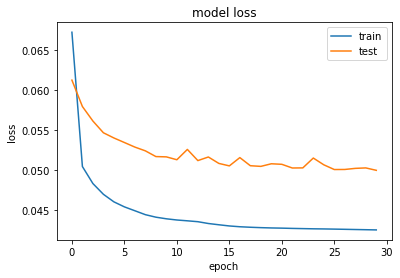

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [28]:
predictions = VarietionalAutoEncoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_test})
error_df.describe()


,reconstruction_error,true_class
count,7.973600e+04,79736.000000
mean,1.058577e-03,0.191118
std,1.692301e-03,0.393184
min,2.318576e-07,0.000000
25%,1.829413e-04,0.000000
50%,5.291549e-04,0.000000
75%,1.252991e-03,0.000000
max,5.215069e-02,1.000000


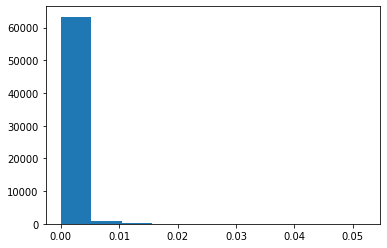

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

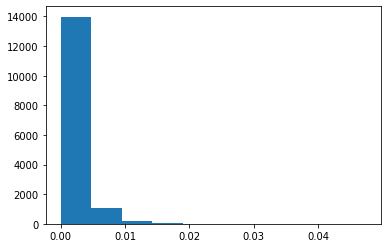

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 1)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

In [31]:
normal_error_df_optout = error_df[(error_df['true_class']== 1)]

In [32]:
normal_error_df_no_optout_no_optout = error_df[(error_df['true_class']== 0)]

In [33]:
normal_error_df_optout['reconstruction_error'].mean()

0.001895061265272243

In [34]:
normal_error_df_optout['reconstruction_error'].max()

0.04735928056879527

In [35]:
normal_error_df_optout['reconstruction_error'].min()

8.060730057030023e-06

In [36]:
normal_error_df_no_optout_no_optout['reconstruction_error'].mean()

0.000860936916152274

In [37]:
normal_error_df_no_optout_no_optout['reconstruction_error'].max()

0.052150686546016164

In [38]:
normal_error_df_no_optout_no_optout['reconstruction_error'].min()

2.3185757928159813e-07

In [39]:
error_df.head()

,reconstruction_error,true_class
503476,0.000282,1
462918,0.000247,0
54768,0.000819,0
237856,0.000319,0
368224,0.000105,0


In [40]:
# error_df['reconstruction_error'] =1- error_df['reconstruction_error']

In [41]:
### Plot fraction of converting customers reached vs. n of deciles targeted
import numpy as np
# all_scores.fillna(0, inplace=True)
deciles = []
recalls = []
precisions = []
thresholds = []
for n in range(1,11):
    
    deciles.append(n)
    
    threshold = np.percentile(error_df.reconstruction_error, np.arange(0,100,10))[-n]
    thresholds.append(threshold)
    
    predictions = []
    for value in error_df.reconstruction_error:
        if value >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
            
    recall = recall_score(error_df.true_class, predictions)
    
    recalls.append(recall)
    


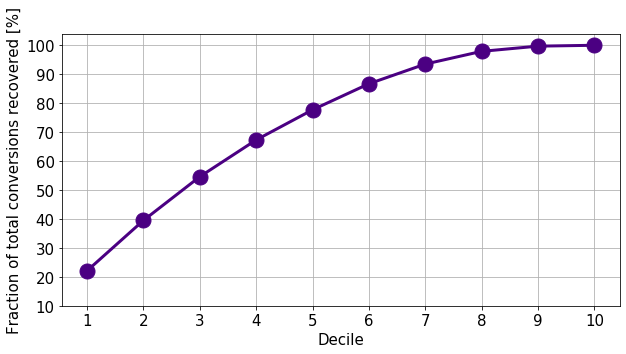

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(deciles, [round(x*100,1) for x in recalls], marker='o', c='Indigo', markersize=15, linewidth=3)
plt.xlabel('Decile', fontsize=15)
plt.ylabel('Fraction of total conversions recovered [%]', fontsize=15)
plt.xticks(np.arange(1, 10+1, 1), fontsize=15)
plt.yticks(np.arange(10, 100+1, 10), fontsize=15)
plt.grid()
plt.show()

In [43]:
#VarietionalAutoEncoder.save('./model_artifacts/autoencoder_model_time')

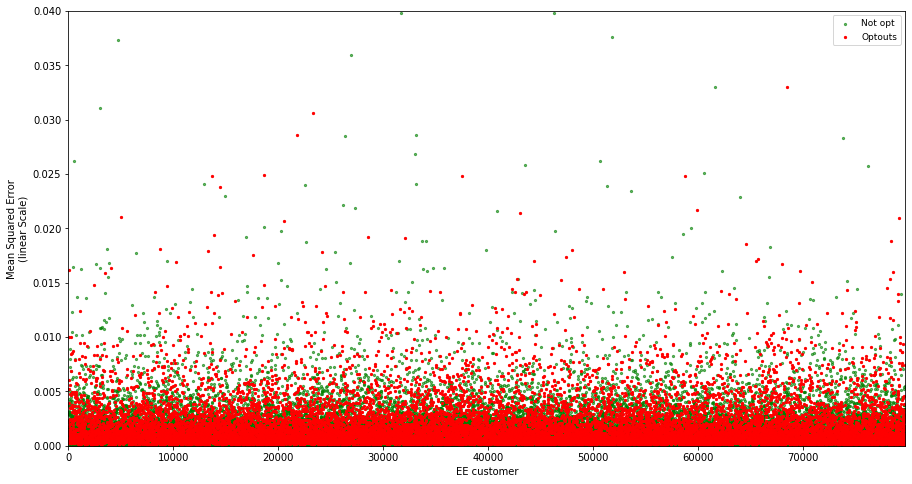

In [44]:
reconstructions=VarietionalAutoEncoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
data = np.column_stack((range(len(mse)), mse))

# scatter's x & y
clean_x, clean_y = data[Y_test==0][:,0], data[Y_test==0][:,1]
fraud_x, fraud_y = data[Y_test==1][:,0], data[Y_test==1][:,1]

# instantiate new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot reconstruction errorsted ou
ax.scatter(clean_x, clean_y, s=5, color='g', alpha=0.6, label='Not opt')
ax.scatter(fraud_x, fraud_y, s=5.00, color='r', alpha=1,   label='Optouts')


# change scale to log & limit x-axis range
ax.set_yscale('linear')
ax.set_ylim(0,0.04)
ax.set_xlim(0, len(mse))

# title & labels

ax.set_xlabel('EE customer')
ax.set_ylabel('Mean Squared Error\n(linear Scale)')

# orange legend for threshold value
ax.legend(loc='upper right', prop={'size': 9})

# display
fig.show();

# Out of Sample performance

In [45]:
# loaded_model = keras.models.load_model("./model_artifacts/autoencoder_model_time")

In [46]:
sql_code = '''
select * from campaign_data.opt_out_202009_all_combined_comm
'''
iterator= athena.execute_query(sql_code, **{'chunksize':100000})

2020-11-17 09:59:47,381 [INFO ]  starting Athena query ...
2020-11-17 10:05:43,329 [INFO ]  loading 1406fba7-fc78-430e-94f5-1adc1f1c0e21.csv
2020-11-17 10:05:44,490 [INFO ]  Athena query complete: returning iterator object


In [47]:
scores_list = []
i=0
for chunk in iterator:
    print(i)
    print( chunk.groupby('optout_flag')['optout_flag'].count())
    chunk = numeric_fill_na(chunk)
    chunk = categorical_fill_na(chunk)
    chunk = replacing_empty_strings(chunk)
    #del chunk['account_num']
    del chunk['optout_date']
    #del chunk['activesub']
    del chunk['ee_customer_id']
    del chunk['optout_cnt']
   
    X_out = chunk.loc[:, chunk.columns != 'optout_flag']
    Y_out = chunk.optout_flag.values
    X_out = one_hot_encoding_test(X_out)
    X_out = scaler.transform(X_out)
    predictions = VarietionalAutoEncoder.predict(X_out)
    mse = np.mean(np.power(X_out - predictions, 2), axis=1)
    df_final = pd.DataFrame(columns = ['prediction', 'actual'])
    df_final['prediction'] = mse
    df_final['actual'] = Y_out
    scores_list.append(df_final)
    print(df_final.actual.unique())
    i=i+1
    #del X_out
    del predictions
    del df_final
    del chunk

0
optout_flag
1    190
Name: optout_flag, dtype: int64
[0 1]
1
optout_flag
1    184
Name: optout_flag, dtype: int64
[0 1]
2
optout_flag
1    191
Name: optout_flag, dtype: int64
[0 1]
3
optout_flag
1    199
Name: optout_flag, dtype: int64
[0 1]
4
optout_flag
1    194
Name: optout_flag, dtype: int64
[0 1]
5
optout_flag
1    186
Name: optout_flag, dtype: int64
[0 1]
6
optout_flag
1    202
Name: optout_flag, dtype: int64
[0 1]
7
optout_flag
1    187
Name: optout_flag, dtype: int64
[0 1]
8
optout_flag
1    179
Name: optout_flag, dtype: int64
[0 1]
9
optout_flag
1    186
Name: optout_flag, dtype: int64
[0 1]
10
optout_flag
1    166
Name: optout_flag, dtype: int64
[0 1]
11
optout_flag
1    172
Name: optout_flag, dtype: int64
[0 1]
12
optout_flag
1    203
Name: optout_flag, dtype: int64
[0 1]
13
optout_flag
1    194
Name: optout_flag, dtype: int64
[0 1]
14
optout_flag
1    192
Name: optout_flag, dtype: int64
[0 1]
15
optout_flag
1    206
Name: optout_flag, dtype: int64
[0 1]
16
optout_flag
1  

In [48]:
all_scores = pd.concat(scores_list, ignore_index=True)

In [49]:
### Plot fraction of converting customers reached vs. n of deciles targeted
import numpy as np
# all_scores.fillna(0, inplace=True)
deciles = []
recalls = []
precisions = []
thresholds = []
for n in range(1,11):
    
    deciles.append(n)
    
    threshold = np.percentile(all_scores.prediction, np.arange(0,100,10))[-n]
    thresholds.append(threshold)
    
    predictions = []
    for value in all_scores.prediction:
        if value >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
            
    recall = recall_score(all_scores.actual, predictions)
    
    recalls.append(recall)
    
    precision = precision_score(all_scores.actual, predictions)
    
    precisions.append(precision)

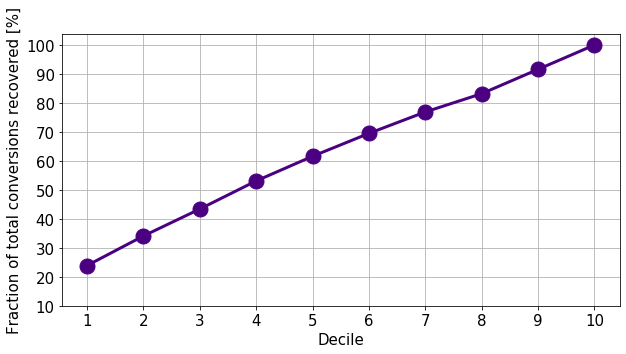

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(deciles, [round(x*100,1) for x in recalls], marker='o', c='Indigo', markersize=15, linewidth=3)
plt.xlabel('Decile', fontsize=15)
plt.ylabel('Fraction of total conversions recovered [%]', fontsize=15)
plt.xticks(np.arange(1, 10+1, 1), fontsize=15)
plt.yticks(np.arange(10, 100+1, 10), fontsize=15)
plt.grid()
plt.show()

# 2 times better than random 

In [51]:
recalls

[0.23912009512485136,
 0.3409036860879905,
 0.43448275862068964,
 0.5310344827586206,
 0.616052318668252,
 0.6954815695600476,
 0.7686087990487515,
 0.8321046373365042,
 0.915576694411415,
 1.0]